In [1]:
import torch
from transformers import AutoTokenizer
from sae_lens import HookedSAETransformer, SAE
from collections import defaultdict
import pandas as pd
import json
from tqdm import tqdm
import transformer_lens.utils as utils
import csv

## Setup

In [2]:
MODEL_NAME   = "meta-llama/Llama-3.1-8B"
HF_TOKEN     = "..."
FEATURES_CSV = "./found_features.csv"
DEV_PROMPTS  = "./prompts_dataset_dev.json"
TEST_PROMPTS = "./prompts_dataset_test_de.json"
# LAYERS       = [15, 16]
LAYERS       = [15, 16]
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'

# Seed
torch.manual_seed(0)
torch.set_grad_enabled(False)

Load Model & Tokenizer

In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, token=HF_TOKEN)
model = HookedSAETransformer.from_pretrained(
    MODEL_NAME, 
    device_map="auto", 
    use_auth_token=HF_TOKEN
).to(DEVICE)
model.eval()

if tokenizer.pad_token is None:
    # reuse eos_token as pad
    tokenizer.pad_token = tokenizer.eos_token

/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/transformers/models/auto/auto_factory.py:476: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model meta-llama/Llama-3.1-8B into HookedTransformer
Moving model to device:  cuda


Load SAEs for each layer and collect feature indices

In [4]:
# Read CSV of chosen features (with columns: label, layer, feature)
# dims_map[label][layer] = (features, alpha)
df = pd.read_csv(FEATURES_CSV)
dims_map = defaultdict(lambda: defaultdict(list))
for _, row in df.iterrows():
    lbl = row['label']
    lyr = int(row['layer'])
    feat = int(row['feature'])
    alpha = float(row['alpha_amplify'])
    dims_map[lbl][lyr].append({'feature': feat, 'alpha': alpha})
    
dims_map

defaultdict(<function __main__.<lambda>()>,
            {'past': defaultdict(list,
                         {15: [{'feature': 15316, 'alpha': 10.0},
                           {'feature': 23112, 'alpha': 7.0},
                           {'feature': 28855, 'alpha': 10.0},
                           {'feature': 30777, 'alpha': 9.0}],
                          16: [{'feature': 1221, 'alpha': 8.0},
                           {'feature': 3638, 'alpha': 7.0}]}),
             'present': defaultdict(list,
                         {15: [{'feature': 5112, 'alpha': 4.0},
                           {'feature': 7890, 'alpha': 8.0},
                           {'feature': 15706, 'alpha': 6.0},
                           {'feature': 26492, 'alpha': 10.0},
                           {'feature': 30777, 'alpha': 7.0}],
                          16: [{'feature': 3638, 'alpha': 4.0},
                           {'feature': 5215, 'alpha': 6.0},
                           {'feature': 7895, 'alpha': 9.0},
    

In [5]:
# Pre-load SAE modules
saes = {}
for layer in LAYERS:
    hook_name = f"blocks.{layer}.hook_resid_post"
    sae_module, _, _ = SAE.from_pretrained(
        release="Yusser/multilingual_llama3.1-8B_saes",
        sae_id=hook_name,
        device=DEVICE
    )
    sae_module.eval()
    saes[sae_module.cfg.hook_name] = sae_module

print(saes.keys())

/auto/brno2/home/ariuka/tense/venv/lib/python3.10/site-packages/sae_lens/sae.py:151: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


dict_keys(['blocks.15.hook_resid_post', 'blocks.16.hook_resid_post'])


### Helper functions

In [6]:
# ScaledSAE wrapper at module scope
torch.set_grad_enabled(False)
class ScaledSAE(torch.nn.Module):
    def __init__(self, base_sae, idxs, alphas, hook):
        super().__init__()
        self.sae   = base_sae
        self.idxs  = idxs
        self.alphas = alphas
        self.cfg   = base_sae.cfg
        self.cfg.hook_name = hook

    def forward(self, z):
        h = self.sae.encode(z)
#         if self.idxs:
# #             h[:, :, self.idxs] *= self.alpha
#             for i, idx in enumerate(self.idxs):
#                 h[:, :, idx] *= self.alpha[i]
            
        for idx, alpha in zip(self.idxs, self.alphas):
            h[:, :, idx] *= alpha
            
        return self.sae.decode(h)

In [7]:
# Baseline (original LM) evaluation
def evaluate_baseline(prompts):
    counts, corrects = defaultdict(int), defaultdict(int)
    for ex in prompts:
        toks = tokenizer(ex['prompt_text'], return_tensors='pt').to(DEVICE)
        logits, _ = model.run_with_cache(toks.input_ids)
        next_id = logits[0, -1].argmax()
        pred = tokenizer.decode(next_id.unsqueeze(0), skip_special_tokens=True).strip()
        lbl = ex['gold_tense']
        counts[lbl] += 1
        if pred and pred[0] == ex['gold_answer']:
            corrects[lbl] += 1
    return {lbl: corrects[lbl]/counts[lbl] for lbl in counts}

# --- Evaluate with run_with_saes (scaling or ablation) ---
def evaluate_with_saes(prompts, target_label, layers, alpha_override=None):
    counts, corrects = defaultdict(int), defaultdict(int)
    # build SAEs list
    scaled = []
    for lyr in LAYERS:
        hook = utils.get_act_name('resid_post', lyr)
        base = saes[hook]
        
        if lyr in layers and target_label in dims_map:
            info = dims_map[target_label][lyr]
            idxs = [entry['feature'] for entry in info]
            if alpha_override is not None:
                alphas = [alpha_override]*len(idxs)
            else:
                alphas = [entry['alpha'] for entry in info]
        else:
            idxs, alphas = [], []
            
        scaled.append(ScaledSAE(base, idxs, alphas, hook))
        
#         if lyr in layers and target_label in dims_map and dims_map[target_label][lyr]:
#             feature_info = dims_map[target_label][lyr]
#             idxs = [entry['feature'] for entry in feature_info]
#             scaled_alpha = [alpha if alpha is not None else entry['alpha'] for entry in feature_info]
#         else:
#             idxs = []
#             scaled_alpha = []
#         scaled.append(ScaledSAE(base, idxs, scaled_alpha, hook))
        
#         if lyr in layers and target_label in dims_map and dims_map[target_label][lyr]['features']:
#             idxs = dims_map[target_label][lyr]['features']
#             scaled_alpha = alpha if alpha is not None else dims_map[target_label][lyr]['alpha']
#         else:
#             idxs = []
#             scaled_alpha = 1.0
#         scaled.append(ScaledSAE(base, idxs, scaled_alpha, hook))

    with torch.no_grad():
        for ex in prompts:
            toks = tokenizer(ex['prompt_text'], return_tensors='pt', padding=True).to(DEVICE)
            logits = model.run_with_saes(toks.input_ids, saes=scaled)
            next_id = logits[0, -1].argmax()
            pred = tokenizer.decode(next_id.unsqueeze(0), skip_special_tokens=True).strip()
            lbl = ex['gold_tense']
            counts[lbl] += 1
            if pred and pred[0] == ex['gold_answer']:
                corrects[lbl] += 1
    return {lbl: corrects[lbl]/counts[lbl] for lbl in counts}

# Wrapper to run different settings
def run_it(mode, layers, alpha, prompts):
    results = []
    if mode == 'baseline_orig':
        acc = evaluate_baseline(prompts)
        results.append({
            'setting': mode, 
            'layers': '', 
            'alpha': '', 
            'target_label': '',
            **{f'accuracy_{k}':v for k,v in acc.items()}
        })
    elif mode == 'baseline_saes':
        acc = evaluate_with_saes(prompts, None, [], 1.0)
        results.append({
            'setting': mode, 
            'layers': layers, 
            'alpha': '', 
            'target_label': '',
            **{f'accuracy_{k}':v for k,v in acc.items()}
        })
    else:
        for lbl in dims_map:
            acc = evaluate_with_saes(prompts, lbl, layers, alpha)
            results.append({
                'setting': mode, 
                'layers': layers, 
                'alpha': alpha, 
                'target_label': lbl,
                **{f'accuracy_{k}':v for k,v in acc.items()}
            })
    return results

# Load test prompts
def load_prompts(path):
    return json.load(open(path))

## Demo test on dev set before test set

In [8]:
prompts = load_prompts(DEV_PROMPTS)

### Test set (aaaaaaaaaaaaaaa)

In [9]:
prompts    = load_prompts(TEST_PROMPTS)
OUTPUT_CSV = "evaluation_results_de.csv"
fieldnames = ['setting','layers','alpha','target_label',
              'accuracy_past','accuracy_present','accuracy_future']

In [12]:
with open(OUTPUT_CSV, 'w', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()

    # Baselines
    for row in run_it('baseline_orig', [],     None, prompts):
        writer.writerow(row)
    for row in run_it('baseline_saes', [],     1.0,  prompts):
        writer.writerow(row)

#     # Amplified
#     for layers in ([15], [16], [15,16]):
#         results = run_it('amplified', layers, None, prompts)
#         for row in results:
#             writer.writerow(row)

#     # Weakened (0.0)
#     for layers in ([15], [16], [15,16]):
#         results = run_it('weakened', layers, 0.0, prompts)
#         for row in results:
#             writer.writerow(row)

#     # Weakened (0.5)
#     for layers in ([15], [16], [15,16]):
#         results = run_it('weakened', layers, 0.5, prompts)
#         for row in results:
#             writer.writerow(row)

print("Done, phew, results saved to", OUTPUT_CSV)

Done, phew, results saved to evaluation_results_de.csv


In [13]:
with open(OUTPUT_CSV, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    # Amplified
    for layers in ([15], [16], [15,16]):
        results = run_it('amplified', layers, 5.0, prompts)
        for row in results:
            writer.writerow(row)

print("Done, phew, results saved to", OUTPUT_CSV)

Done, phew, results saved to evaluation_results_de.csv


In [14]:
with open(OUTPUT_CSV, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    # Amplified
    for layers in ([15], [16], [15,16]):
        results = run_it('amplified', layers, 10.0, prompts)
        for row in results:
            writer.writerow(row)

print("Done, phew, results saved to", OUTPUT_CSV)

Done, phew, results saved to evaluation_results_de.csv


In [10]:
with open(OUTPUT_CSV, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    # Amplified
    for layers in ([15], [16], [15,16]):
        results = run_it('amplified', layers, 2.0, prompts)
        for row in results:
            writer.writerow(row)

print("Done, phew, results saved to", OUTPUT_CSV)

Done, phew, results saved to evaluation_results_de.csv


In [11]:
with open(OUTPUT_CSV, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    # Amplified
    for layers in ([15], [16], [15,16]):
        results = run_it('weakened', layers, 0.1, prompts)
        for row in results:
            writer.writerow(row)

print("Done, phew, results saved to", OUTPUT_CSV)

Done, phew, results saved to evaluation_results_de.csv


In [12]:
with open(OUTPUT_CSV, 'a', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)

    # Amplified
    for layers in ([15], [16], [15,16]):
        results = run_it('weakened', layers, 0, prompts)
        for row in results:
            writer.writerow(row)

print("Done, phew, results saved to", OUTPUT_CSV)

Done, phew, results saved to evaluation_results_de.csv


## Visualization

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# 1. Load & melt
df = pd.read_csv('evaluation_results_de.csv')
long = df.melt(
    id_vars=['setting','target_label','alpha','layers'],
    value_vars=['accuracy_past','accuracy_present','accuracy_future'],
    var_name='tense',
    value_name='accuracy'
)
long['tense'] = long['tense'].str.replace('accuracy_','')

In [15]:
# 2. Build condition strings including α and layers
def make_cond(row):
    if row['setting'] == 'baseline_orig':
        return 'baseline'
    if row['setting'] == 'baseline_saes':
        return 'α=1.0 / L15_16'
    # rows for amplified/weakened
    layers_str = str(row['layers']).strip('[]').replace(' ','').replace(',','_')
#     return f"{row['setting']}/α={row['alpha']}/L{layers_str}"
    return f"α={row['alpha']} / L{layers_str}"

long['cond'] = long.apply(make_cond, axis=1)

# 3. Define masks
mask_base = long['setting'].isin(['baseline_orig','baseline_saes'])

# for amplified @ α=5.0 on each layer‐combination
mask_amp_15    = (
    (long['setting']=='amplified') &
    (long['alpha']==5.0) &
    (long['layers']=='[15]') &
    (long['tense']==long['target_label'])
)
mask_amp_16    = (
    (long['setting']=='amplified') &
    (long['alpha']==5.0) &
    (long['layers']=='[16]') &
    (long['tense']==long['target_label'])
)
mask_amp_15_16 = (
    (long['setting']=='amplified') &
    (long['alpha']==5.0) &
    (long['layers']=='[15, 16]') &
    (long['tense']==long['target_label'])
)

# for weakened @ α=0.0 on each layer‐combination
mask_weak_15    = (
    (long['setting']=='weakened') &
    (long['alpha']==0.0)  &
    (long['layers']=='[15]') &
    (long['tense']==long['target_label'])
)
mask_weak_16    = (
    (long['setting']=='weakened') &
    (long['alpha']==0.0)  &
    (long['layers']=='[16]') &
    (long['tense']==long['target_label'])
)
mask_weak_15_16 = (
    (long['setting']=='weakened') &
    (long['alpha']==0.0)  &
    (long['layers']=='[15, 16]') &
    (long['tense']==long['target_label'])
)

filtered = long[
    mask_base
    | mask_amp_15    | mask_amp_16    | mask_amp_15_16
    | mask_weak_15   | mask_weak_16   | mask_weak_15_16
]

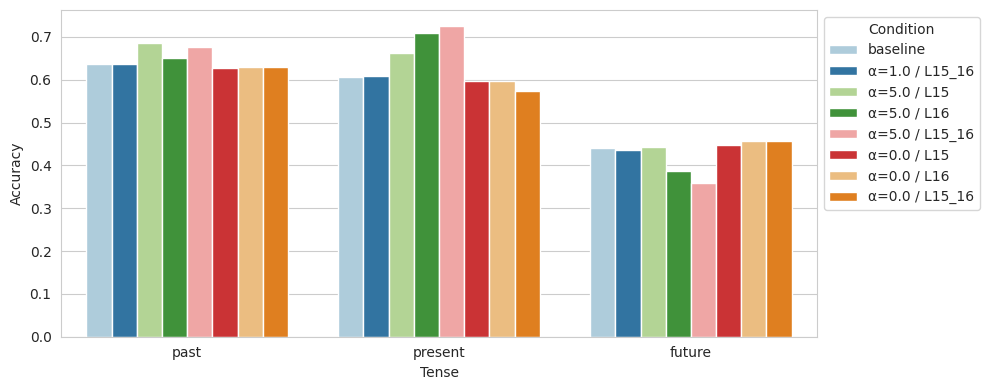

In [16]:
# 4. Explicit hue order
hue_order = [
    'baseline',
    'α=1.0 / L15_16',
    'α=5.0 / L15',
    'α=5.0 / L16',
    'α=5.0 / L15_16',
    'α=0.0 / L15',
    'α=0.0 / L16',
    'α=0.0 / L15_16',
]

# 4. Plot
sns.set_style('whitegrid')
plt.figure(figsize=(10,4))
sns.barplot(
    data=filtered,
    x='tense',
    y='accuracy',
    hue='cond',
    hue_order = hue_order,
    palette='Paired',
    errorbar=None
)
# plt.ylim(0,1)
plt.xlabel('Tense')
plt.ylabel('Accuracy')
plt.legend(title='Condition', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()